<a href="https://colab.research.google.com/github/chase-capron/ImageProcessing/blob/master/Counting_Coins.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [421]:
# Uploading File to Colab notebook
from google.colab import files
uploaded = files.upload()

# Used to verify if file has been uploaded
for file in uploaded.keys():
  print('Uploaded file "{name}" with length {length} bytes'.format(name=file, length=len(uploaded[file])))

Saving Test1.png to Test1.png
Uploaded file "Test1.png" with length 499128 bytes


In [0]:
# Importing necessary Image Processing libraries
import numpy as np
import matplotlib.pyplot as plt
from skimage import color
%matplotlib inline

def display(im, title=None, **kwargs):
    kwargs['cmap'] = 'gray'
    plt.figure() # Creates a seperate window for viewing an Image
    plt.imshow(im, **kwargs) # Displays the image using cmap arguments
    plt.title(title)
    plt.axis('off') # Turns off the plot axis's to just display the Image
    return im

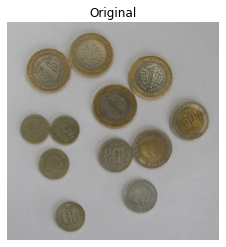

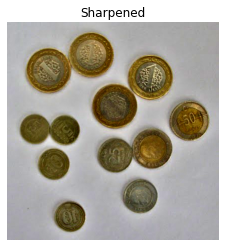

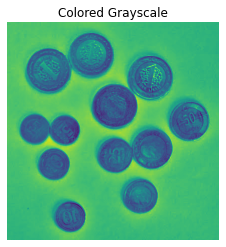

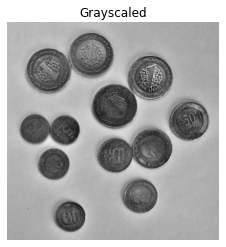

In [423]:
# Reads in the Image file to an array my_image
# To use another Image, upload multiple images and replace the file name in my_image
my_image = plt.imread('Test2.png') # [Insert file name here]

# Mask to Sharpen the Image for pre-processing (Helps distinquish coins from background)
from skimage.filters import unsharp_mask
rad = 20.0 # Change this to adjust Sharpening intensity
sharp_im = unsharp_mask(my_image, radius = rad) # New Sharpened Image

# Displaying Original and new Sharpened Image
display(my_image, 'Original', cmap=None) # Display uploaded Image
display(sharp_im, 'Sharpened', cmap=None) # Display Sharpened Image

# Creating Colored Grayscale
heat = color.rgb2gray(sharp_im) # Defaults to Grayscaling the image as a colored Heatmap just for reference
plt.figure()
plt.imshow(heat)
plt.title('Colored Grayscale')
plt.axis('off')

# Creating True Grayscale with Color Map
gray = display(heat, 'Grayscaled') # No cmap argument defaults to cmap='gray'

array([[False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       ...,
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False]])

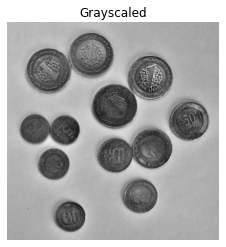

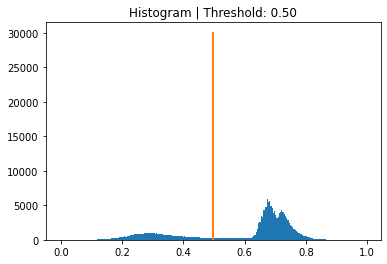

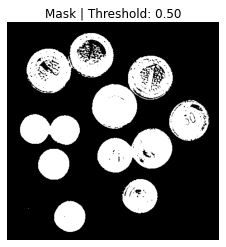

In [424]:
# Creating a Thresholding Mask
from skimage.filters import threshold_otsu

# Using a Otsu method Thresholder from skimage library
gray = display(heat, 'Grayscaled')
thresh = threshold_otsu(gray, nbins=5) # Determines the Threshold value for the border of coins, 5 bins optimizes the coin images the best
binary = gray > thresh  # New Binary mask

plt.figure()
plt.hist(gray.ravel(), bins=250); # Displays Histogram of Gray values in Image
plt.title('Histogram | Threshold: %.2f' % thresh) # Sets threshold to 2 decimal places
plt.plot([thresh, thresh], [0,30000], linewidth=2)

is_white = False
if(binary[0,0]): #If the corner pixel value of the binary image is white, the image will be inverted to adjust for white backgrounds
  binary=~binary
  is_white = True

display(binary, 'Mask | Threshold: %.2f' % thresh) # Displays the new Binary Image

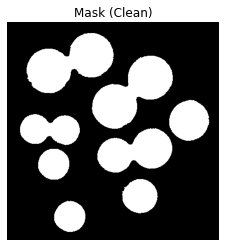

In [425]:
# Cleaning up the Mask for final processing
from skimage import morphology
from skimage.morphology import disk

disks = morphology.binary_closing(binary, disk(5)) # Removes small background noise by performing a dilation followed by an erosion

no_holes = morphology.remove_small_objects(disks, min_size=700) # Removes objects smaller than 150 pixels

mask_filter = ~morphology.remove_small_objects(~no_holes) # Removes black noise from the inverse color of 'disks' and then reverts image back


mask = display(mask_filter, 'Mask (Clean)')

(-0.5, 421.5, 432.5, -0.5)

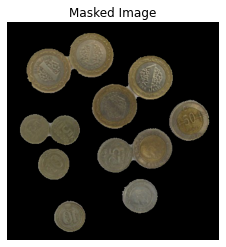

In [426]:
# Applies the Mask to the Original Image of the coins
my_image[~mask] = 0 # Applies black mask to image
plt.imshow(my_image)
plt.title('Masked Image')
plt.axis('off')

Number of Regions Detected: 12


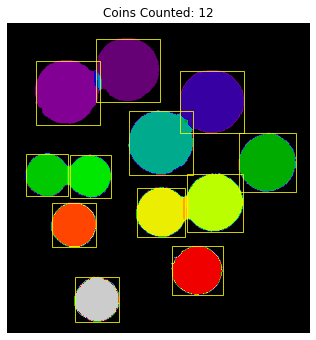

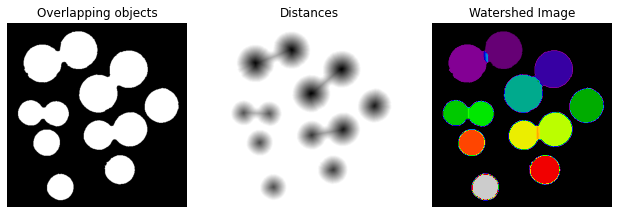

In [427]:
import matplotlib.patches as mpatches

from skimage import measure
from skimage import data
from skimage.filters import threshold_otsu
from skimage.segmentation import clear_border, watershed
from skimage.feature import peak_local_max
from skimage.measure import label, regionprops
from skimage.morphology import closing, square

def watershed_segmentation(im):
    distance_im = ndi.distance_transform_edt(im)
    local_max = peak_local_max(distance_im, indices=True)
    peaks_im = np.zeros(distance_im.shape, dtype=bool)
    for row, col in local_max:
        peaks_im[row, col] = 1
    markers = label(peaks_im)
    labelled_im = watershed(-distance_im, markers, mask=im)
    return labelled_im

distance = ndi.distance_transform_edt(mask)
labels = watershed_segmentation(mask)

image = labels


# Remove objects along image border
cleared = clear_border(image)

# Label the image regions
label_image = label(cleared)

fig, ax = plt.subplots(figsize=(4.5, 6))
ax.imshow(label_image, "nipy_spectral")

count = 0
for region in regionprops(label_image):
    # If image has a white background, set a seperate area threshold
    if is_white == True:
      area_thresh = 500
    else:
      area_thresh = 1350
    if region.area >= area_thresh:
        # Draws a Rectangle around the detected regions.
        minr, minc, maxr, maxc = region.bbox
        box = mpatches.Rectangle((minc, minr), maxc - minc, maxr - minr,
                                  fill=False, edgecolor='yellow', linewidth=0.8)
        count = count + 1
        ax.add_patch(box)

print("Number of Regions Detected: %.0f" % count)
ax.set_axis_off()
plt.tight_layout()
plt.title('Coins Counted: %.0f' % count)
plt.show()

# Configuring the code to display images as one
fig, axes = plt.subplots(ncols=3, figsize=(9, 3), sharex=True, sharey=True)
ax = axes.ravel() # Flattens the image to 1-D array

# Displaying Image arrays in subplots
ax[0].imshow(mask, cmap='gray')
ax[0].set_title('Overlapping objects')
ax[1].imshow(-distance, cmap='gray')
ax[1].set_title('Distances')
ax[2].imshow(label_image, cmap='nipy_spectral')
ax[2].set_title('Watershed Image')

for a in ax:
    a.set_axis_off()

fig.tight_layout()
plt.show()